### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# 1. Folder Structure

The `data_processing_codes` folder consists of scripts for processing weather, soil, elevation, and satellite datasets. A list of description of what each script does is provided below-

1. __process_utils.ipynb :__ This scripts consists of  all functions required for processing weather, soil, elevation, and satellite datasets that have been queried from CSW/other sources. Functions include shapefile to raster conversion, reading/writing raster data, resample and masking raster data, processing era5/twc datasets, etc.
2. __Exp_DA_satellite_data.ipynb :__ This scripts explores insights from the satellite datasets, especially satellite land surface temperature data.
3. __Exp_DA_weather_data.ipynb :__ This scripts explores insights from the ERA5 and TWC weather datasets. It also has a section with analysis of ERA5 vs satellite soil moisture data..
4. __processing_daily_LST_data.ipynb :__ This script processes satelite Land Surface temperature (LST) data for the Woodland site.
5. __processing_daily_weather_data.ipynb :__ This script processes ERA5 and TWC weather datasets for our Region of Interest (ROI) to different resolutions and also compiles the datasets into `dataframe for ML/DL models`.
6. __processing_DEM_slope_data.ipynb :__ This script processes SRTM DEM data for the ROI.
7. __processing_soil250_data.ipynb :__ This script processes soil25 datasets for the ROI.
8. __EDA_satellite_results :__ This is a `folder` that consists of some results generated by the `Exp_DA_satellite_data.ipynb` script.



### For data processing steps, please refer to individual processing scripts.

-------------

# 2. Sequence for Script Running 

- The `processing_utils`is a standalone scripts `supporting the other data processing scripts`. There is no need to run it separately. The processing scripts will import functions from this script and use them as needed. 
<br />

- The following processing/data exploration scripts should be run in the following sequene -
    - `processing_DEM_slope_data.ipynb`
    - `processing_daily_weather_data.ipynb`
    - `Exp_DA_weather_data.ipynb`

- The `processing_soil250_data.ipynb`, `processing_daily_LST_data.ipynb`, and `Exp_DA_satellite_data.ipynb` scripts are standalone and are not dependent on the other scripts. So, they can be run in any sequence.

----------------

# 3. General Discussion

## 3.1 Region of Interest (ROI)
We chose some `selected cities in Califoania` as the Region of Interest (ROI). The ROI consists of some parts of the Central Valley, California that has significant agriculture. The ROI selection was based on consideration that it should overlap some `Testing Fields` in that region. 

The ERA5 and TWC weather datasets were downloaded for a `buffer region around the ROI`. That's because the queried ERA5 and TWC data are of low to moderate spatial resolution (28km and 4km respectively) and in later steps of the pipeline we need to interpolate (bilinear resampling) the datasets into rasters. If we only downloaded the data for our original ROI, the interpolation results along the borders of the ROI might not do well. So, we created a buffer for our ROI and downloaded the weather datasets for that buffer regions to maintain interpolation quality. In later stesp of the pipeline, we will mask the interpolated weather datasets with our original ROI.

The following plot represents the shapefile covering the `ROI`. The `black` outline around the ROI is the `ROI Buffer`.

<Axes: >

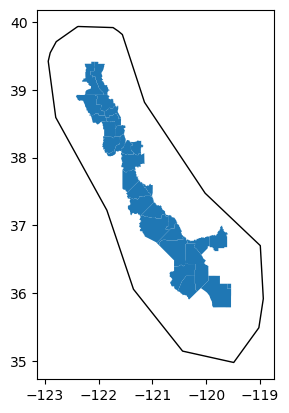

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

roi = gpd.read_file('../shapefiles_grids/selected_cities_California.shp')
roi_buffer = gpd.read_file('../shapefiles_grids/cities_California_buffer.shp')

fig, ax = plt.subplots()
roi.plot(ax=ax)
roi_buffer.plot(facecolor='none', edgecolor='black', ax=ax)

## 3.2 Reference Rasters

In the data processing steps, a number of reference rasters were used to rasterize and resample the datasets. Most of the reference rasters were created from respective shapefile using `QGIS` `Rasterize (vector to Raster)` tool. The `shapefiles` used to create the refernece rasters are stored in `../shapefiles_grids` folder. The `reference rasters` used are stored in `../reference_rasters` folder. 

The following __notes__ will be helpful to regerate the reference rasters- 

- For creating any reference raster for the `ROI Buffer` use the `../shapefiles_grids/cities_California_buffer.shp` shapefile
- For creating any reference raster for the `ROI` use the `../shapefiles_grids/cities_California_dissolved.shp` shapefile
- For creating 4km reference raster use the following inputs in QGIS
        
        - fixed value to burn - 0
        - output raster size unit - Georeferenced units
        - width/horizontal size units - 0.036
        - height/vertical size units - 0.036
        - output extent - calculate from layer > select the respective shapefile
        - assign a specified nodata value to output bands -  -9999
        
- For creating 8km reference raster use the following inputs in QGIS
        
        - fixed value to burn - 0
        - output raster size unit - Georeferenced units
        - width/horizontal size units - 0.072
        - height/vertical size units - 0.072
        - output extent - calculate from layer > select the respective shapefile
        - assign a specified nodata value to output bands -  -9999
        
- For creating 28km reference raster use the following inputs in QGIS
        
        - fixed value to burn - 0
        - output raster size unit - Georeferenced units
        - width/horizontal size units - 0.25
        - height/vertical size units - 0.25
        - output extent - calculate from layer > select the respective shapefile
        - assign a specified nodata value to output bands -  -9999
        
        
- For creating 28km reference raster use the following inputs in QGIS
        
        - fixed value to burn - 0
        - output raster size unit - Georeferenced units
        - width/horizontal size units - 0.0008888888888893356228
        - height/vertical size units - 0.0008888888888893356228
        - output extent - calculate from layer > select the respective shapefile
        - assign a specified nodata value to output bands -  -9999    
        
- As 100m refernece raster for the `Woodland site` (100m ARD's ROI), use a randomly chosen satellite soil moisture or land surface temperature data for Woodland site.     
        
Here, the height-width values of the 4km//8km/28km rasters were assigned considering `111.10 km=1 deg`. For the 100m raster height-width value was assigned based on the resolution of available satellite soil moisture and land surface temperature data.

__Note:__ After creating the reference rasters with `QGIS` `Rasterize (vector to Raster)` tool, I noticed that in the `raster information` the height and width value is not ecatly what was assigned. I am not sure what's causing this. 

------------

## 3.3 Why `Bilinear Resampling`

Studies have found minimal to no difference between bilinear and krigging interpolation. Billinear is a special case of krigging ([Shao et al. 2006](https://cfpub.epa.gov/ncer_abstracts/index.cfm/fuseaction/display.files/fileID/14459), [Carletti et al. 2000](https://link.springer.com/article/10.1023/A:1006293110652)). Moreover, testing both krigging and bilinear methods have shown that bilinear is a much faster/computationally efficient method than krigging, especially with high resolution dataset like soil250 (250m).


Bilinear resampling also works better than nearest neighbour resampling. Mostly because bilinear takes average of 4 neighboring pixels to resample and catches average weather pattern of a pixel better. [Link1](https://desktop.arcgis.com/en/arcmap/latest/extensions/spatial-analyst/performing-analysis/cell-size-and-resampling-in-analysis.htm) and [Link2](https://gisgeography.com/bilinear-interpolation-resampling/) suggest in general why bilinear performs better. 

---------

## 3.4 Center of TWC rasterized data and TWC grid center not matching
There might be some `slight shift` in rasterized TWC/ERA5 datasets from the TWC/ERA5 polygon grids's center (center-to-center doesn't match). This is because during the rasterization process, we used `cities_california_buffer_28km_refraster / cities_california_buffer_4km_refraster`  as reference rasters. Thse reference rasters were not created using the TWC/ERA5 polygon grids file, rather `cities_California_buffer.shp` shapefile. During the rasterization process, the `rasterize_shapefile()` function is only concerned about matching the height-width of the rasterized data with the reference rasters. In future, for establishing the center-to-center match between rasterized data and grid polygon center, the rasterization process should take into account both reference raster height and width and grid cell center. Anyway, this shouldn't affect much in the modeling effort but it is recommneded to use a reference raster created from TWC polygon grids in future.

This center-to-center not matching issue might also be due to the issues `4km resolution issue of TWC data` and `8km resolution issue of TWC High-Res Precipitation data`

## 3.5 4km resolution issue of TWC data

In CSW, the TWC historical weather dataset resolution is mentioned as 4km. Based on that `0.036 deg` was chosen as the pixel size (in `WGS 1984 (EPSG:4326)` coordinate system) for all 4km rasters. The 4km reference was also created with `0.036 deg` grid size. Later on, while investigating the `Center of TWC rasterized data and TWC grid center not matching` issue, I noticed that TWC grid size isn't exactly 4km, rather center to center of TWC grids are at `4884.010m`distance. The following figure that estimated by QGIS Measure tool. While rasterizining TWC historical datasets in the future, this cell size issue should be considered.

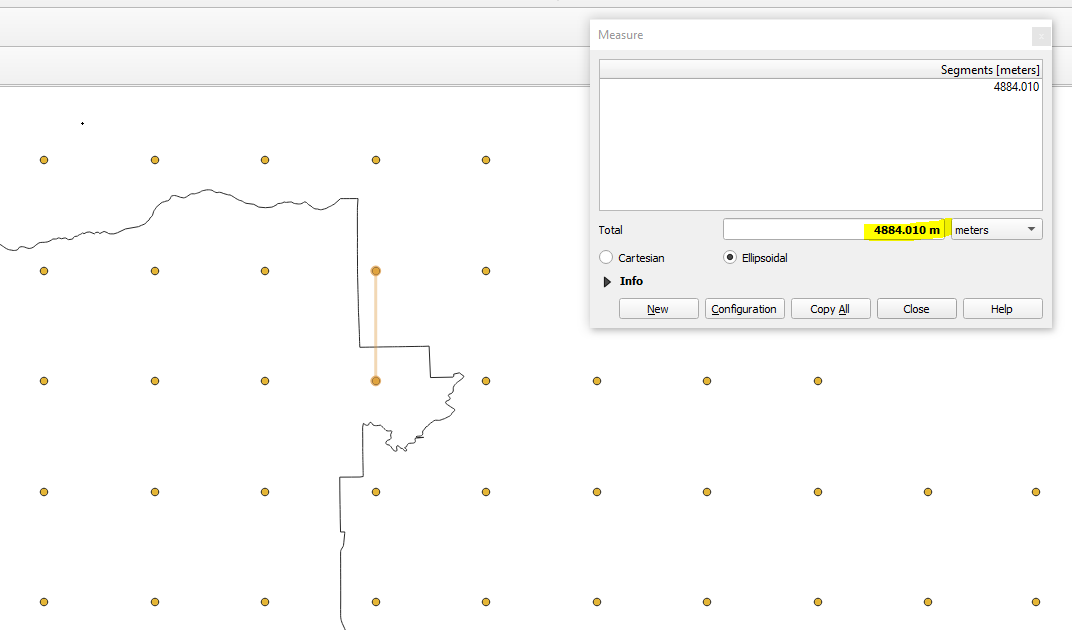 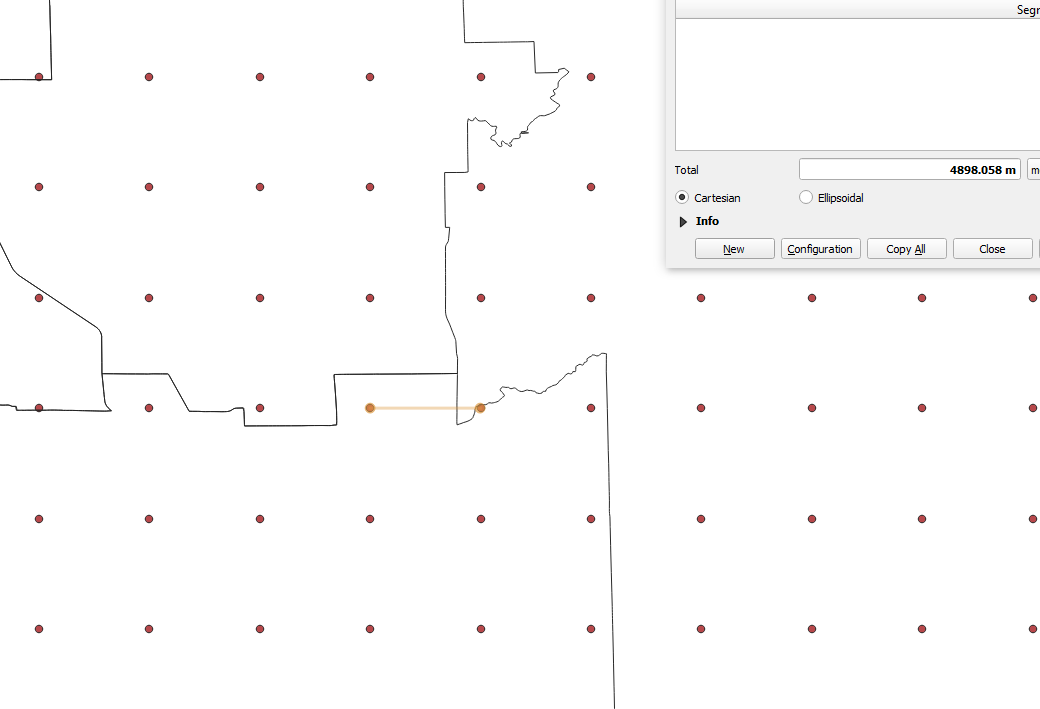

-------

## 3.6 8km resolution issue of TWC High-Res Precipitation data

In CSW, the TWC High-Res precip dataset resolution is mentioned as 8km. Based on that `0.072 deg` was chosen as the pixel size (in `WGS 1984 (EPSG:4326)` coordinate system) for all 4km rasters. The 8km reference was also created with `0.072 deg` grid size. Later on, while investigating the `Center of TWC rasterized data and TWC grid center not matching` issue, I noticed that TWC High-Res grid size isn't exactly 8km, rather it varies. One other thing is - unlike TWC historical weather datasets (the grids are parallel to each other and each grid is perfectly at `~4884 m`distance, the TWC High-Res precip grids are not parallel. The following plot shows that. While rasterizining TWC High-Res precipitation datasets in the future, this cell size and non-parallel issues should be considered.

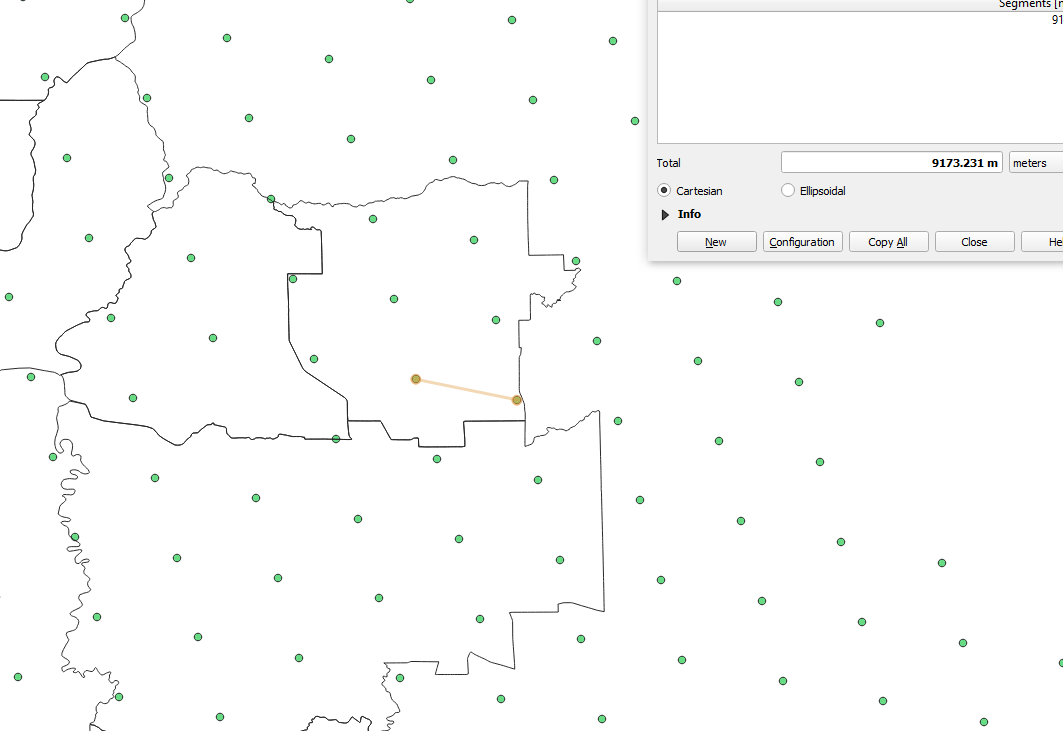 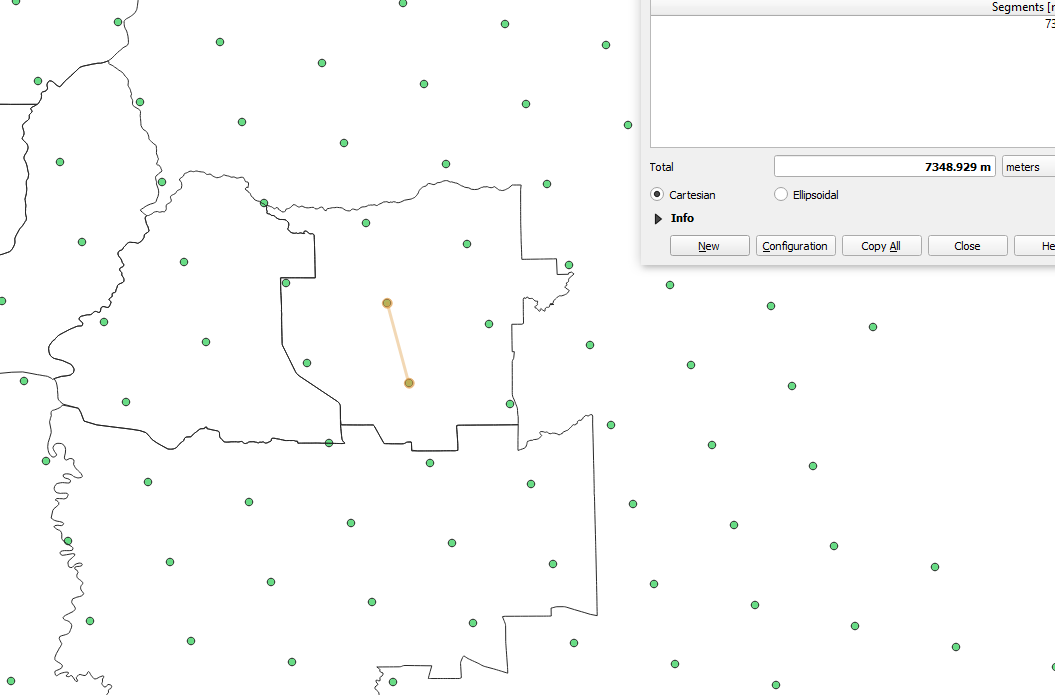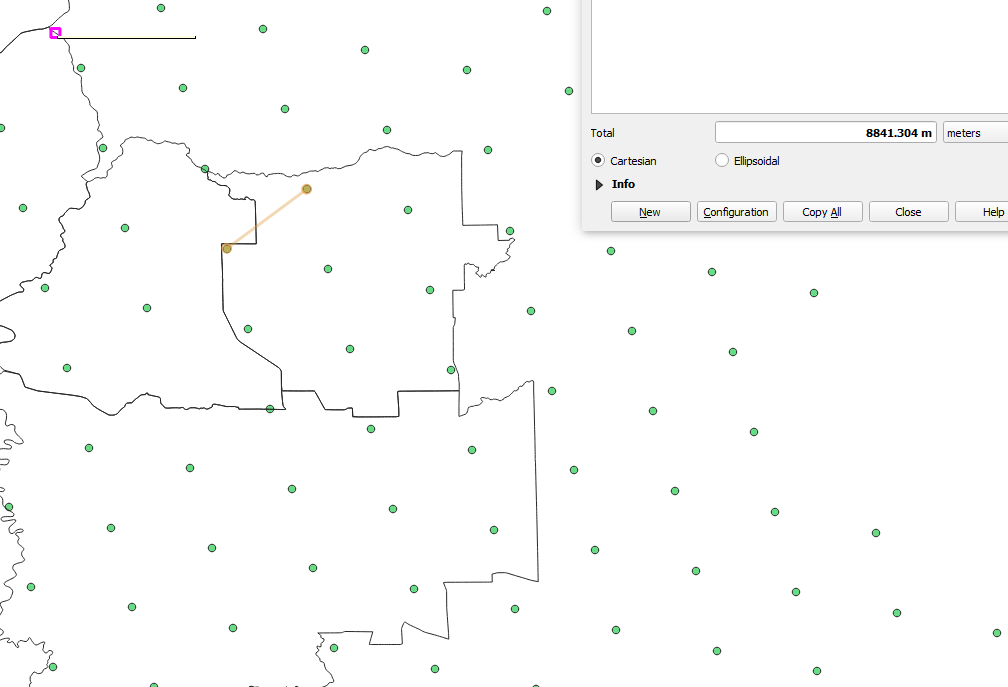

---

## 3.7 TWC High-Res precipitation `grid point to polygon` conversion issue

The TWC High-Res precipitation grids were first converted from grid centers to 8km grid polygons. After that these grid polygons were used to rasterize the dataset to 8km rasters (detail steps in `processing_daily_weather_data.ipynb` script). Due to the   `3.5 8km resolution issue of TWC High-Res Precipitation data` issue, converting from grid centers to 8km grid polygons created overalapping polygon issue (`scale-like polygons`). These `scale-like polygons` might have affected rasterization values of TWC High-Res precipitation dataset and eventually contributed to `unsatisfactory results of total precipitation` model. Both issue `3.6` and `3.7` should be addressed in future before rasterizing TWC High-Res precip data. The following plot shows the scale like polygons-

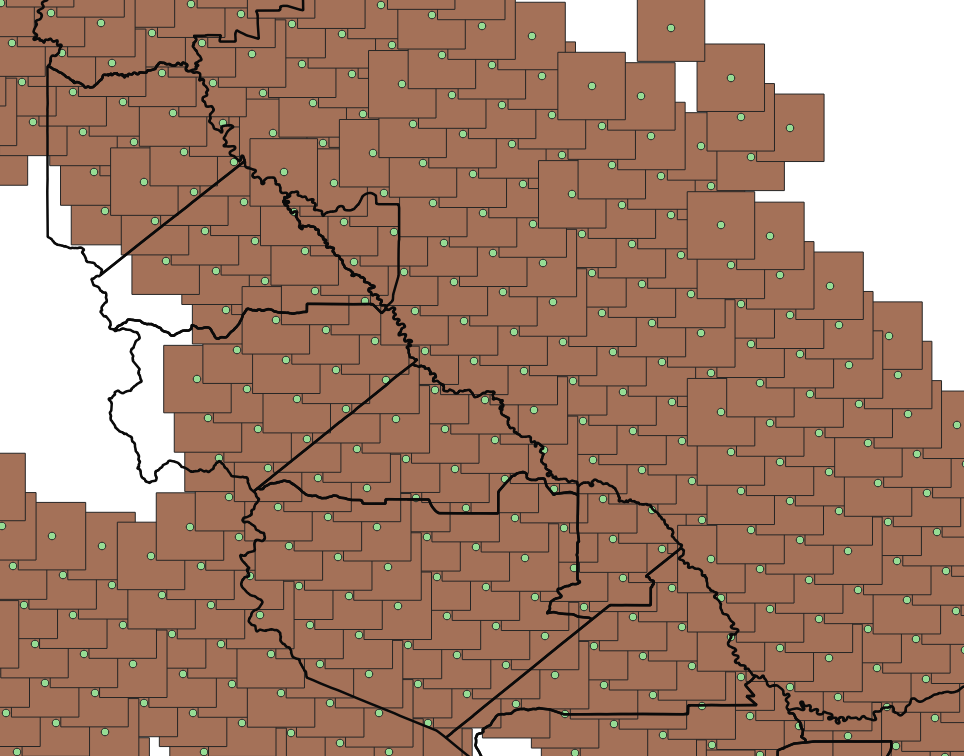

-------------

## 3.8 Dataset Making Issue with `Rasterio` based function

While processing weather datasets, datasets were masked from ROI Buffer extent to the original ROI extent using the ROi shapefile. I used `rasterio`-based `mask_raster_array_by_shapefile()` function for performing the mask. I noticed that the masked raster shape (height-width) doesn't not match with the shape of reference rasters (there is +/-1 change in height/width value). The rasterio library has many known issues like this which can be avoided by using `gdal based masking`. Unfortunately, I could not figure out gdal in this AWS instance. 